In [1]:
import sys
sys.path.insert(0, f'D:/OneDrive/Program/GitHub/EasyIDP')

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
from easyric.objects import Pix4D
from easyric.io import shp, geotiff, plot
from easyric.calculate import geo2raw, geo2tiff

In [3]:
project_name = 'broccoli_tanashi_5_20200528_P4M_10m_before'
project_path = f"Z:/共享云端硬盘/broccoliProject/tanashi_broccoli2020_RGB_AP/{project_name}"
raw_img_folder=f"Z:/共享云端硬盘/broccoliProject/rgb_raw/{project_name}"
label_folder = f"Z:/共享云端硬盘/broccoliProject/pred_bbox/{project_name}/labels"
param_folder = f"{project_path}/params"

In [4]:
p4d = Pix4D(project_path=project_path, 
            raw_img_path=raw_img_folder, 
            project_name=project_name,
            param_folder=param_folder)

[Init][Pix4D] No ply given, however find 'broccoli_tanashi_5_20200528_P4M_10m_before_group1_densified_point_cloud.ply' at current project folder
[Init][Pix4D] No dom given, however find 'broccoli_tanashi_5_20200528_P4M_10m_before_transparent_mosaic_group1.tif' at current project folder
[Init][Pix4D] No dsm given, however find 'broccoli_tanashi_5_20200528_P4M_10m_before_dsm.tif' at current project folder
[io][geotiff][GeoCorrd] Comprehense [* 34737 geo_ascii_params (30s) b'WGS 84 / UTM zone 54N|WGS 84|'] to geotiff coordinate tag [WGS 84 / UTM zone 54N]
[io][geotiff][GeoCorrd] Comprehense [* 34737 geo_ascii_params (30s) b'WGS 84 / UTM zone 54N|WGS 84|'] to geotiff coordinate tag [WGS 84 / UTM zone 54N]


In [5]:
from easyric.caas_lite import TiffSpliter

grid_len = 1300
buffer_len = 200

In [6]:

ts = TiffSpliter(tif_path=p4d.dom_file, grid_h=grid_len, grid_w=grid_len, grid_buffer=buffer_len)

# read labels to python

In [7]:
import os

In [8]:
label_list = os.listdir(label_folder)
label_list[:10]

['grid_x07_y09.txt',
 'grid_x06_y16.txt',
 'grid_x07_y13.txt',
 'grid_x07_y08.txt',
 'grid_x07_y11.txt',
 'grid_x07_y06.txt',
 'grid_x07_y10.txt',
 'grid_x07_y04.txt',
 'grid_x07_y05.txt',
 'grid_x07_y12.txt']

In [9]:
x_id, y_id = ts.name2id(label_list[0], 'txt')
x_id, y_id

(7, 9)

In [10]:
ts.wgrid_st[x_id], ts.hgrid_st[y_id]

(9100, 11700)

In [11]:
bbox_pd = pd.DataFrame(columns=['offset_x', 'offset_y', 'xc', 'yc', 'w', 'h'])

for label_txt in label_list:
    print(f"reading {label_txt}", end="\r")
    with open(f"{label_folder}/{label_txt}") as f:
        x_id, y_id = ts.name2id(label_txt, 'txt')
        offset_x, offset_y = ts.wgrid_st[x_id], ts.hgrid_st[y_id]
        for l in f.readlines():
            _, xc, yc, w, h = l.split(' ')

            bbox_pd.loc[len(bbox_pd),:] = [offset_x, offset_y, 
                                           float(xc), float(yc),
                                           float(w), float(h)]

In [12]:
bbox = bbox_pd.astype(np.float32)

In [13]:
bbox['xc'] = bbox['xc'] * (grid_len + buffer_len)
bbox['yc'] = bbox['yc'] * (grid_len + buffer_len)
bbox['w']  = bbox['w'] * (grid_len + buffer_len)
bbox['h']  = bbox['h'] * (grid_len + buffer_len)

bbox['x0'] = bbox['xc'] - bbox['w'] / 2
bbox['x1'] = bbox['xc'] + bbox['w'] / 2
bbox['y0'] = bbox['yc'] - bbox['h'] / 2
bbox['y1'] = bbox['yc'] + bbox['h'] / 2

bbox

,offset_x,offset_y,xc,yc,w,h,x0,x1,y0,y1
0,9100.0,11700.0,370.999512,616.000488,43.999950,55.999947,348.999542,392.999481,588.000488,644.000488
1,9100.0,11700.0,587.500488,345.000000,45.000000,53.999996,565.000488,610.000488,318.000000,372.000000
2,9100.0,11700.0,9.499995,172.000504,19.000051,52.000046,-0.000031,19.000021,146.000488,198.000519
3,9100.0,11700.0,220.500000,16.000050,79.000053,28.000050,180.999969,260.000031,2.000025,30.000074
4,9100.0,11700.0,1294.500000,15.499949,52.999947,21.000000,1268.000000,1321.000000,4.999949,25.999950
...,...,...,...,...,...,...,...,...,...,...
10201,10400.0,9100.0,1289.500488,548.500488,64.999947,73.000053,1257.000488,1322.000488,512.000488,585.000488
10202,10400.0,9100.0,925.000488,136.999954,61.999950,67.999947,894.000488,956.000488,102.999985,170.999924
10203,10400.0,9100.0,503.500519,1162.999512,61.000050,78.000000,473.000488,534.000549,1123.999512,1201.999512
10204,10400.0,9100.0,184.500000,981.000000,70.999947,76.000053,149.000031,219.999969,943.000000,1019.000000


In [14]:
bbox = bbox.round(0)
bbox = bbox.astype(np.uint16)
bbox

,offset_x,offset_y,xc,yc,w,h,x0,x1,y0,y1
0,9100,11700,371,616,44,56,349,393,588,644
1,9100,11700,588,345,45,54,565,610,318,372
2,9100,11700,9,172,19,52,0,19,146,198
3,9100,11700,220,16,79,28,181,260,2,30
4,9100,11700,1294,15,53,21,1268,1321,5,26
...,...,...,...,...,...,...,...,...,...,...
10201,10400,9100,1290,549,65,73,1257,1322,512,585
10202,10400,9100,925,137,62,68,894,956,103,171
10203,10400,9100,504,1163,61,78,473,534,1124,1202
10204,10400,9100,184,981,71,76,149,220,943,1019


In [15]:
bbox.dtypes

offset_x    uint16
offset_y    uint16
xc          uint16
yc          uint16
w           uint16
h           uint16
x0          uint16
x1          uint16
y0          uint16
y1          uint16
dtype: object

In [16]:
bbox_demo = bbox[(bbox.offset_x == 9100) & (bbox.offset_y == 11700)]
bbox_demo.head()

,offset_x,offset_y,xc,yc,w,h,x0,x1,y0,y1
0,9100,11700,371,616,44,56,349,393,588,644
1,9100,11700,588,345,45,54,565,610,318,372
2,9100,11700,9,172,19,52,0,19,146,198
3,9100,11700,220,16,79,28,181,260,2,30
4,9100,11700,1294,15,53,21,1268,1321,5,26


In [17]:
from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle

In [18]:
for i in range(len(bbox_demo)):
    print(bbox_demo.x0[i])
    break

349


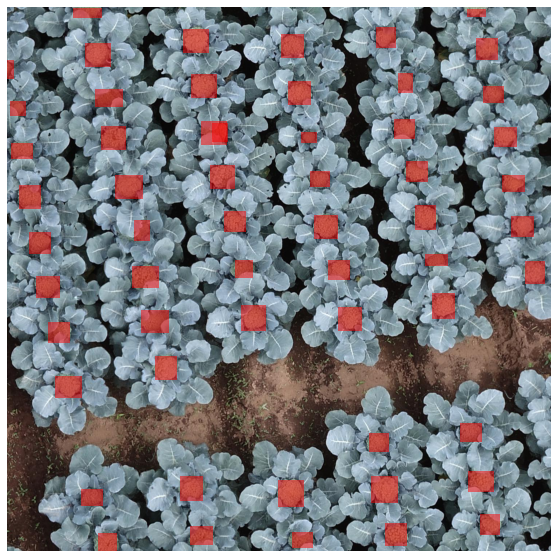

In [19]:
fig, ax = plt.subplots(1,1, figsize=(10,10))

impath = f"Z:/共享云端硬盘/broccoliProject/anotation_use/jpg/{project_name}/{label_list[0][:-4]}.jpg"

ax.imshow(plt.imread(impath))

boxes = []
for i in range(len(bbox_demo)):
    rect = Rectangle((bbox_demo.x0[i], bbox_demo.y0[i]), bbox_demo.w[i], bbox_demo.h[i])
    boxes.append(rect)

pc = PatchCollection(boxes, facecolor='r', alpha=0.5)

ax.add_collection(pc)

ax.axis('off')

plt.show()